In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import lightning as L
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy 
from sklearn.metrics import mean_squared_log_error,mean_squared_error

import random

## Load train data and analyze

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df =pd.read_csv("data/test.csv") 
train_non = train_df.isnull().any()
train_non

warehouse                 False
date                      False
orders                    False
holiday_name               True
holiday                   False
shutdown                  False
mini_shutdown             False
shops_closed              False
winter_school_holidays    False
school_holidays           False
blackout                  False
mov_change                False
frankfurt_shutdown        False
precipitation              True
snow                       True
user_activity_1           False
user_activity_2           False
id                        False
dtype: bool

In [3]:
train_df.head(3)

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07


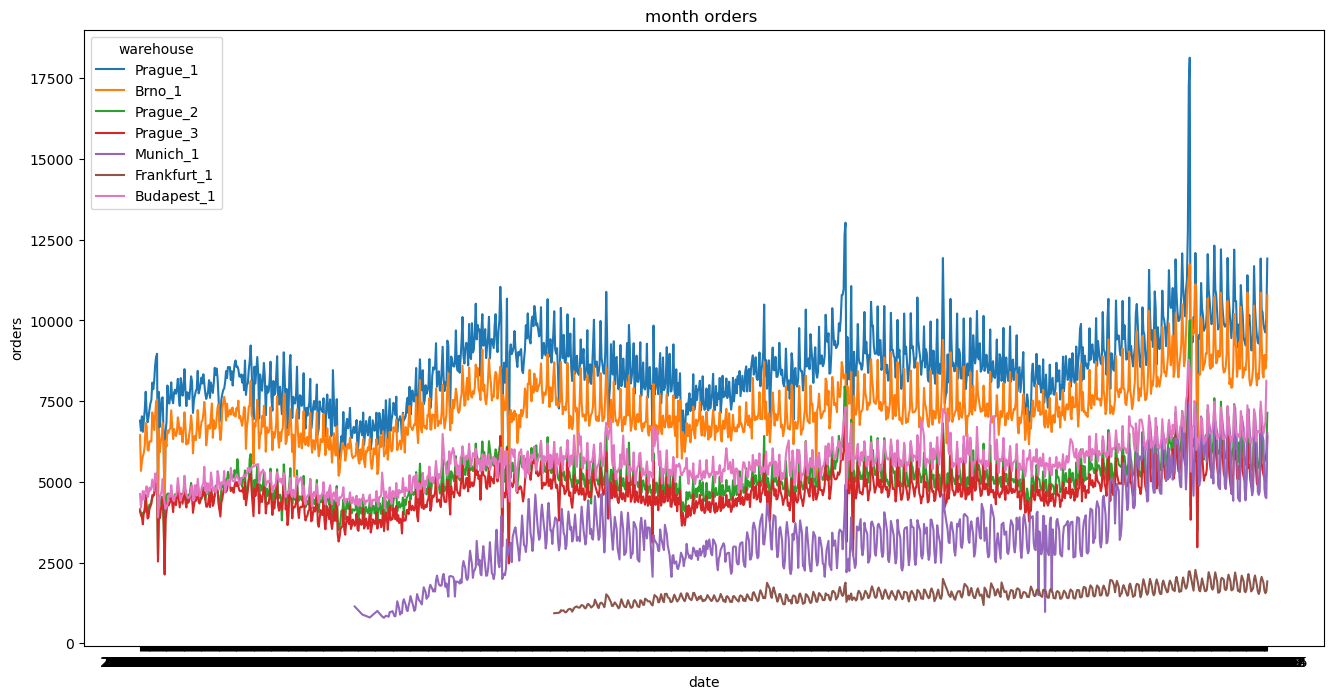

In [5]:
fig = plt.figure(figsize = (16,8))
sns.lineplot(x="date",y="orders",data=train_df,hue = "warehouse")
plt.xlabel("date")
plt.ylabel("orders")
plt.title(f"month orders ")
plt.show()

In [4]:
test_df.head(3)

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18


analyze the influence of the feature of test set on orders

In [10]:
train_test_df = train_df[['orders','date','holiday_name','shops_closed','winter_school_holidays','school_holidays']]
train_test_df['date'] = pd.to_datetime(train_test_df['date'])
# Extract date-related features
train_test_df['quarter'] = train_test_df['date'].dt.quarter
train_test_df['year'] = train_test_df['date'].dt.year
train_test_df['month'] = train_test_df['date'].dt.month
train_test_df['day'] = train_test_df['date'].dt.day
train_test_df['day_of_week'] = train_test_df['date'].dt.dayofweek
train_test_df['day_of_year'] = train_test_df['date'].dt.dayofyear
train_df_copy =train_test_df.select_dtypes(exclude='O').corr()


C:\Users\JAMES\AppData\Local\Temp\ipykernel_22716\3758050825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_df['date'] = pd.to_datetime(train_test_df['date'])
C:\Users\JAMES\AppData\Local\Temp\ipykernel_22716\3758050825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_df['quarter'] = train_test_df['date'].dt.quarter
C:\Users\JAMES\AppData\Local\Temp\ipykernel_22716\3758050825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

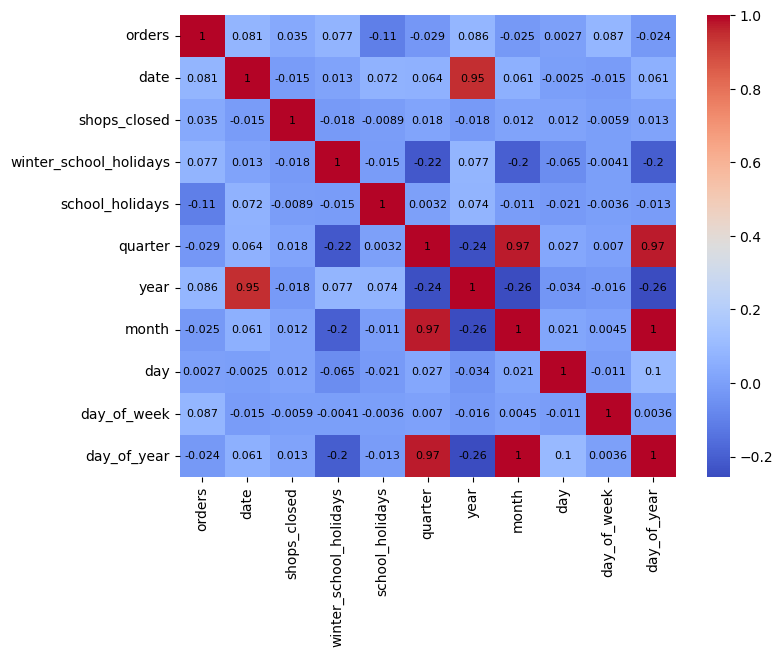

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(data = train_df_copy,annot = True, cmap= 'coolwarm', annot_kws={"size": 8, "color": "black"})
plt.show()

as the plot shows,all ther feature have weak relationships with orders, we could not predict with these features.

find  how the different feature in test set to influence the orders, and preposseing them 

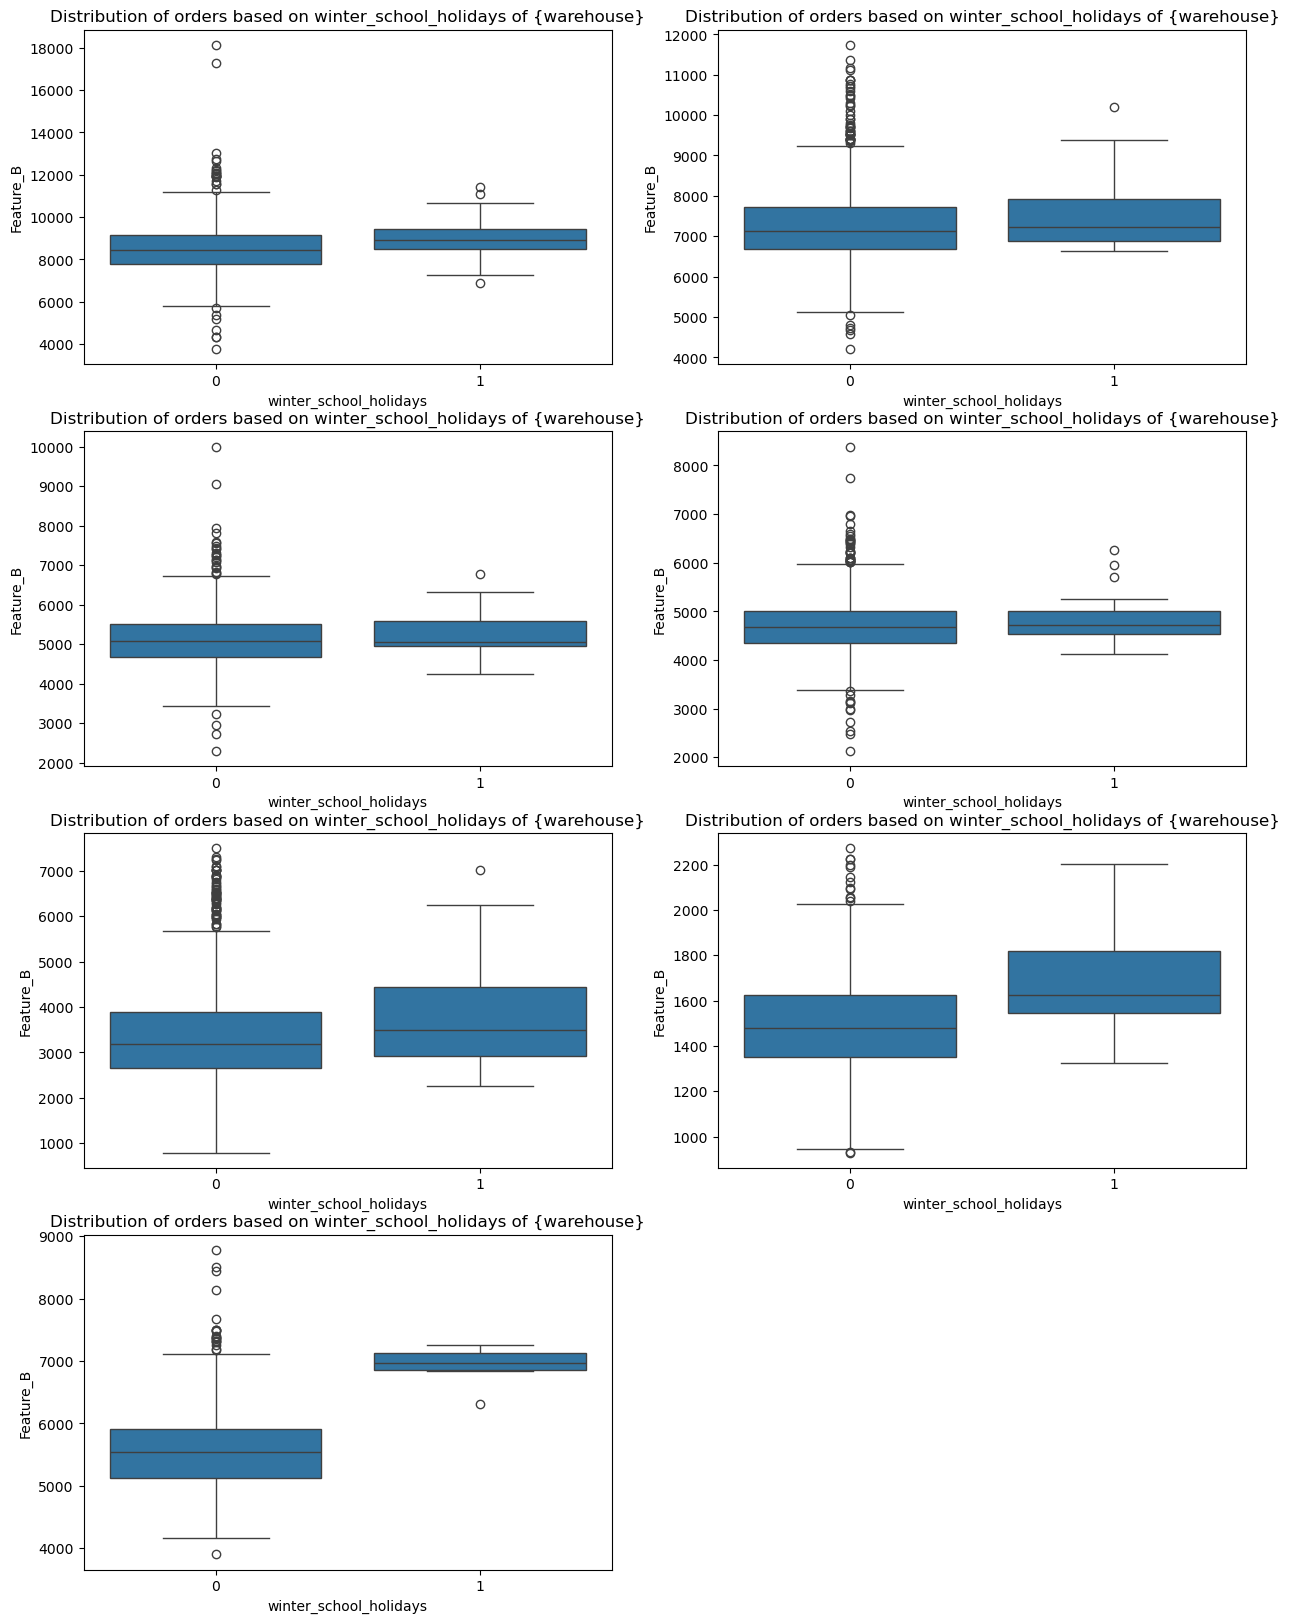

In [6]:
warehouses =train_df['warehouse'].unique()
fig = plt.figure(figsize = (15,20))
i=1
for warehouse in warehouses:
    fig.add_subplot(4,2,i)
    data = train_df[train_df['warehouse']==warehouse]
    sns.boxplot(x='winter_school_holidays', y='orders', data=data)
    plt.xlabel('winter_school_holidays')
    plt.ylabel('Feature_B')
    plt.title('Distribution of orders based on winter_school_holidays of {warehouse}')
    i +=1

plt.show()

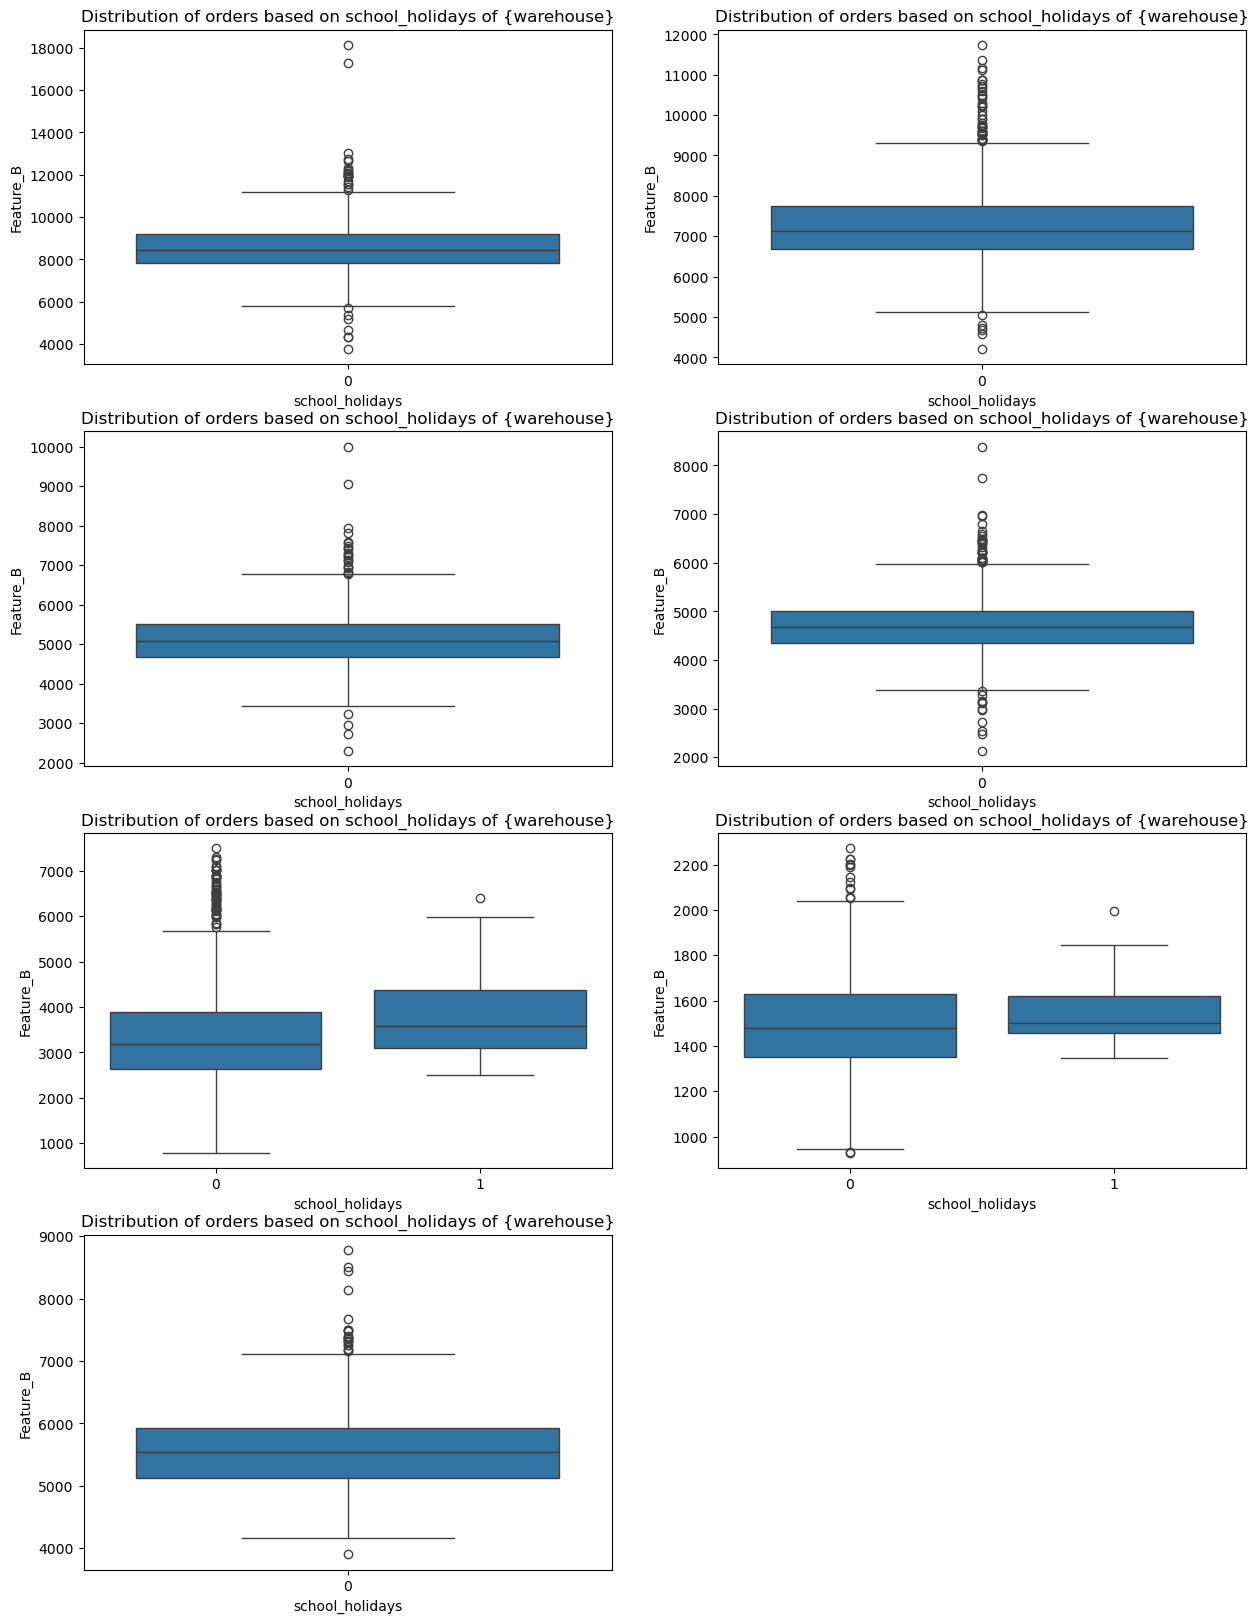

In [7]:
warehouses =train_df['warehouse'].unique()
fig = plt.figure(figsize = (15,20))
i=1
for warehouse in warehouses:
    fig.add_subplot(4,2,i)
    data = train_df[train_df['warehouse']==warehouse]
    sns.boxplot(x='school_holidays', y='orders', data=data)
    plt.xlabel('school_holidays')
    plt.ylabel('Feature_B')
    plt.title('Distribution of orders based on school_holidays of {warehouse}')
    i +=1

plt.show()

prepocess datetime to recycle time for better predict 

In [12]:
def process_date(df):
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract date-related features
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    
    # Create cyclic features
    def cyclical_encode(df, col, max_val):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    
    cyclical_encode(df, 'month', 12)
    cyclical_encode(df, 'day_of_week', 7)
    cyclical_encode(df, 'day_of_year', 365)
    cyclical_encode(df, 'day', 30)

    cat_features = ['day_of_week', 'quarter', 'month', 'day', 'year']
    bin_features = ['is_weekend']
    df=df.drop(cat_features,axis=1)
    return df, bin_features

def prepare_holidays(df):
    df = df.fillna(0)
    holidays =df['holiday_name'].unique()
    df['holidays_id']=pd.factorize(df['holiday_name'])[0]
    df['combined_holidays'] = ((df['winter_school_holidays'] != 0) | (df['school_holidays'] != 0)).astype(int)
    df.drop(['holiday_name','winter_school_holidays','school_holidays'],axis = 1,inplace = True)

    return df,holidays

In [13]:
train_df_new,bin_features =process_date(train_df)
train_df_new,holidays=prepare_holidays(train_df_new)
# holidays,
train_df_new.head(3)

,warehouse,date,orders,holiday,shutdown,mini_shutdown,shops_closed,blackout,mov_change,frankfurt_shutdown,...,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,day_sin,day_cos,holidays_id,combined_holidays
0,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0.0,0,...,-2.449294e-16,1.0,-0.974928,-0.222521,-0.417194,0.908818,0.866025,0.500000,0,0
1,Prague_1,2020-12-06,6584.0,0,0,0,0,0,0.0,0,...,-2.449294e-16,1.0,-0.781831,0.623490,-0.401488,0.915864,0.951057,0.309017,0,0
2,Prague_1,2020-12-07,7030.0,0,0,0,0,0,0.0,0,...,-2.449294e-16,1.0,0.000000,1.000000,-0.385663,0.922640,0.994522,0.104528,0,0


In [10]:
train_df_copy=train_df_new.drop(['id','holiday_name','warehouse'],axis=1, errors='ignore')
train_df_copy =train_df_copy.select_dtypes(exclude='O').corr()

Create model to train

In [20]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        data = self.data[idx]
        label = self.labels[idx]
        return data, label
        

In [21]:
class LSTM(L.LightningModule):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.conv =nn.Sequential(
        #     nn.Conv1d(in_channels=conv_input,out_channels=conv_input,kernel_size=1),
        #  )
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        # self.relu = nn.ReLU()
        self.fc = nn.Sequential(
            nn.Linear(hidden_size,output_size)
        )
        self.criterion =nn.MSELoss()

    def forward(self,x):
        # x = self.conv(x)
        h0= torch.zeros(self.num_layers,x.shape[0],self.hidden_size,device=x.device)
        c0 = torch.zeros(self.num_layers,x.shape[0],self.hidden_size,device=x.device)
        out, _ = self.lstm(x,(h0,c0))
        # out = self.relu(out[:, -1, :])
        
        out = self.fc(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss,y_hat

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return y_hat,loss
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def predict_step(self, batch, batch_idx):
        x,y = batch
        y_hat = self(x)
        return y_hat

In [22]:
def train_test_split(dataX,datay,shuffle=True,percentage=0.8):
    if shuffle:
        indices = np.arange(datay.shape[0])
        shuffled_indices = np.random.permutation(indices)
        dataX = dataX[shuffled_indices]
        datay = datay[shuffled_indices]
    train_size = int(len(dataX)*percentage)
    train_X,test_X = dataX[:train_size], dataX[train_size:]
    train_y,test_y = datay[:train_size], datay[train_size:]
    return train_X,test_X,train_y,test_y
# indicetrain = np.arange(datay.shape[0])

In [41]:
def train_predict(train_load,val_load,test_loader):
    #create model
    early_stop_callback = EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=3)
    
    # Configure Checkpoints
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min"
    )
    lstm= LSTM(input_size,hidden_size,num_layers,output_size)
    # Fit the model
    trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback])
    # trainer = L.Trainer(max_epochs=10)
    trainer.fit(model=lstm, train_dataloaders=train_load, val_dataloaders=val_loader)

    test_pred=trainer.predict(model=lstm, dataloaders = test_loader)
    test_pred=torch.cat(test_pred, dim=0)
    
    return test_pred,lstm

def reverse_predict(scaler,pred_s,n_step,n_features):
    pred = np.zeros((pred_s.shape[0],n_step, n_features))
    pred[:, -1,:1] = pred_s
    pred_reshape = pred.reshape(-1, pred.shape[-1])
    pred_inverse = scaler.inverse_transform(pred_reshape)
    pred_out = pred_inverse.reshape(pred.shape)
    return pred_out[:,-1,:1]
def draw_train_plot(warehouse,order,pred):
    loss =mean_squared_log_error(order,pred)
    print(f'loss of {warehouse}:{loss}')
    # plt.figure(dpi =300,figsize=(10,3))
    plt.plot(order,label='Actual active')
    plt.plot(pred,label='predict')
    # plt.plot(train_y,label='train')
    plt.title(f'orders of {warehouse}' )

def set_random(seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


In [42]:
def getdata( data,n_step=14):
    # cupdata data to time series
    # n_step :window length
    data_np =data[['orders','month_sin','month_cos','day_of_week_sin',
            'day_of_week_cos','day_of_year_sin','day_of_year_cos','day_sin','day_cos']].to_numpy()
    X = []
    for i in range(len(data_np)-n_step):
        row = np.array([r for r in data_np[i:i+n_step+1]])
        X.append(row)
    
    return np.array(X)

In [43]:

warehouses= train_df['warehouse'].unique()

train_df_1 = train_df_new.drop(['id','holiday_name','blackout','mov_change','frankfurt_shutdown','precipitation','snow','shutdown','mini_shutdown','days_since_start'],axis=1, errors='ignore')
test_df_1 =train_df_1[train_df_1['date']>'2023-12-03']
train_df_2 =train_df_1[train_df_1['date']<='2023-12-03']

In [44]:
train_df_2.head(2)

,warehouse,date,orders,holiday,shops_closed,user_activity_1,user_activity_2,day_of_year,is_weekend,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,day_sin,day_cos,holidays_id,combined_holidays
0,Prague_1,2020-12-05,6895.0,0,0,1722.0,32575.0,340,1,-2.449294e-16,1.0,-0.974928,-0.222521,-0.417194,0.908818,0.866025,0.500000,0,0
1,Prague_1,2020-12-06,6584.0,0,0,1688.0,32507.0,341,1,-2.449294e-16,1.0,-0.781831,0.623490,-0.401488,0.915864,0.951057,0.309017,0,0


train data predict 
 the orders time series of are from the actural orders 

In [45]:
# 包含 activity_2 有历史数据，训练并测试
n_step =7

# input_size = 11
input_size = 9

hidden_size= 64
num_layers = 1
output_size=1
warehouses =train_df_1['warehouse'].unique()
out_df = pd.DataFrame()
for warehouse in warehouses:
    set_random(42)
    train_df_warehouse = train_df_2[train_df_2['warehouse']==warehouse]
    train_data= getdata( train_df_warehouse,n_step=n_step)
    print(train_data.shape)
    
    test_df_warehouse = test_df_1[test_df_1['warehouse']==warehouse]
    test_data= getdata( test_df_warehouse,n_step=n_step)

    scaler  = MinMaxScaler()
    train_reshape = train_data.reshape(-1, train_data.shape[-1])
    test_reshape = test_data.reshape(-1, test_data.shape[-1])

    train_scaler_reshape = scaler.fit_transform(train_reshape)
    test_scaler_reshape = scaler.transform(test_reshape)

    train_scaler = train_scaler_reshape.reshape(train_data.shape)
    test_scaler = test_scaler_reshape.reshape(test_data.shape)
    

    train_data_X ,train_data_y= train_scaler[:,:-1,:],train_scaler[:,-1,:1]
    train_data_X =torch.tensor(train_data_X, dtype=torch.float32)
    train_data_y =torch.tensor(train_data_y, dtype=torch.float32)

    
    train_X,val_X,train_y,val_y=train_test_split(train_data_X ,train_data_y,shuffle=False,percentage=0.9)
    
    test_X ,test_y= test_scaler[:,:-1,:],test_scaler[:,-1,:1]
    test_X =torch.tensor(test_X, dtype=torch.float32)
    test_y =torch.tensor(test_y, dtype=torch.float32)
    train_dataset = MyDataset(train_X,train_y)
    val_dataset = MyDataset(val_X,val_y)
    test_dataset = MyDataset(test_X,test_y)
    
    train_loader=DataLoader(train_dataset, batch_size=16,  shuffle=True,num_workers=0)
    val_loader=DataLoader(val_dataset, batch_size=16,  shuffle=False,num_workers=0)
    test_loader=DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=0)


    test_pred_scaler,model=train_predict(train_loader,val_loader,test_loader)
    test_pred=reverse_predict(scaler,test_pred_scaler,n_step+1,train_data.shape[2])
    test_df_warehouse_new =test_df_warehouse.drop(test_df_warehouse.index[:n_step]).reset_index(drop=False)


    test_pred_df = pd.DataFrame(test_df_warehouse_new, columns=['orders_pred'])
    test_pred_df.index=test_df_warehouse_new.index
    result = pd.concat([test_df_warehouse_new, test_pred_df], axis=1)
    
    out_df = pd.concat([out_df, result], axis=0)
    # draw_train_plot(warehouse,result,test_pred)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 19.2 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


(1084, 8, 9)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 19.2 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


(1084, 8, 9)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 19.2 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


(1084, 8, 9)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 19.2 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


(1084, 8, 9)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 19.2 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


(693, 8, 9)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 19.2 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


(536, 8, 9)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 19.2 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


(1048, 8, 9)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

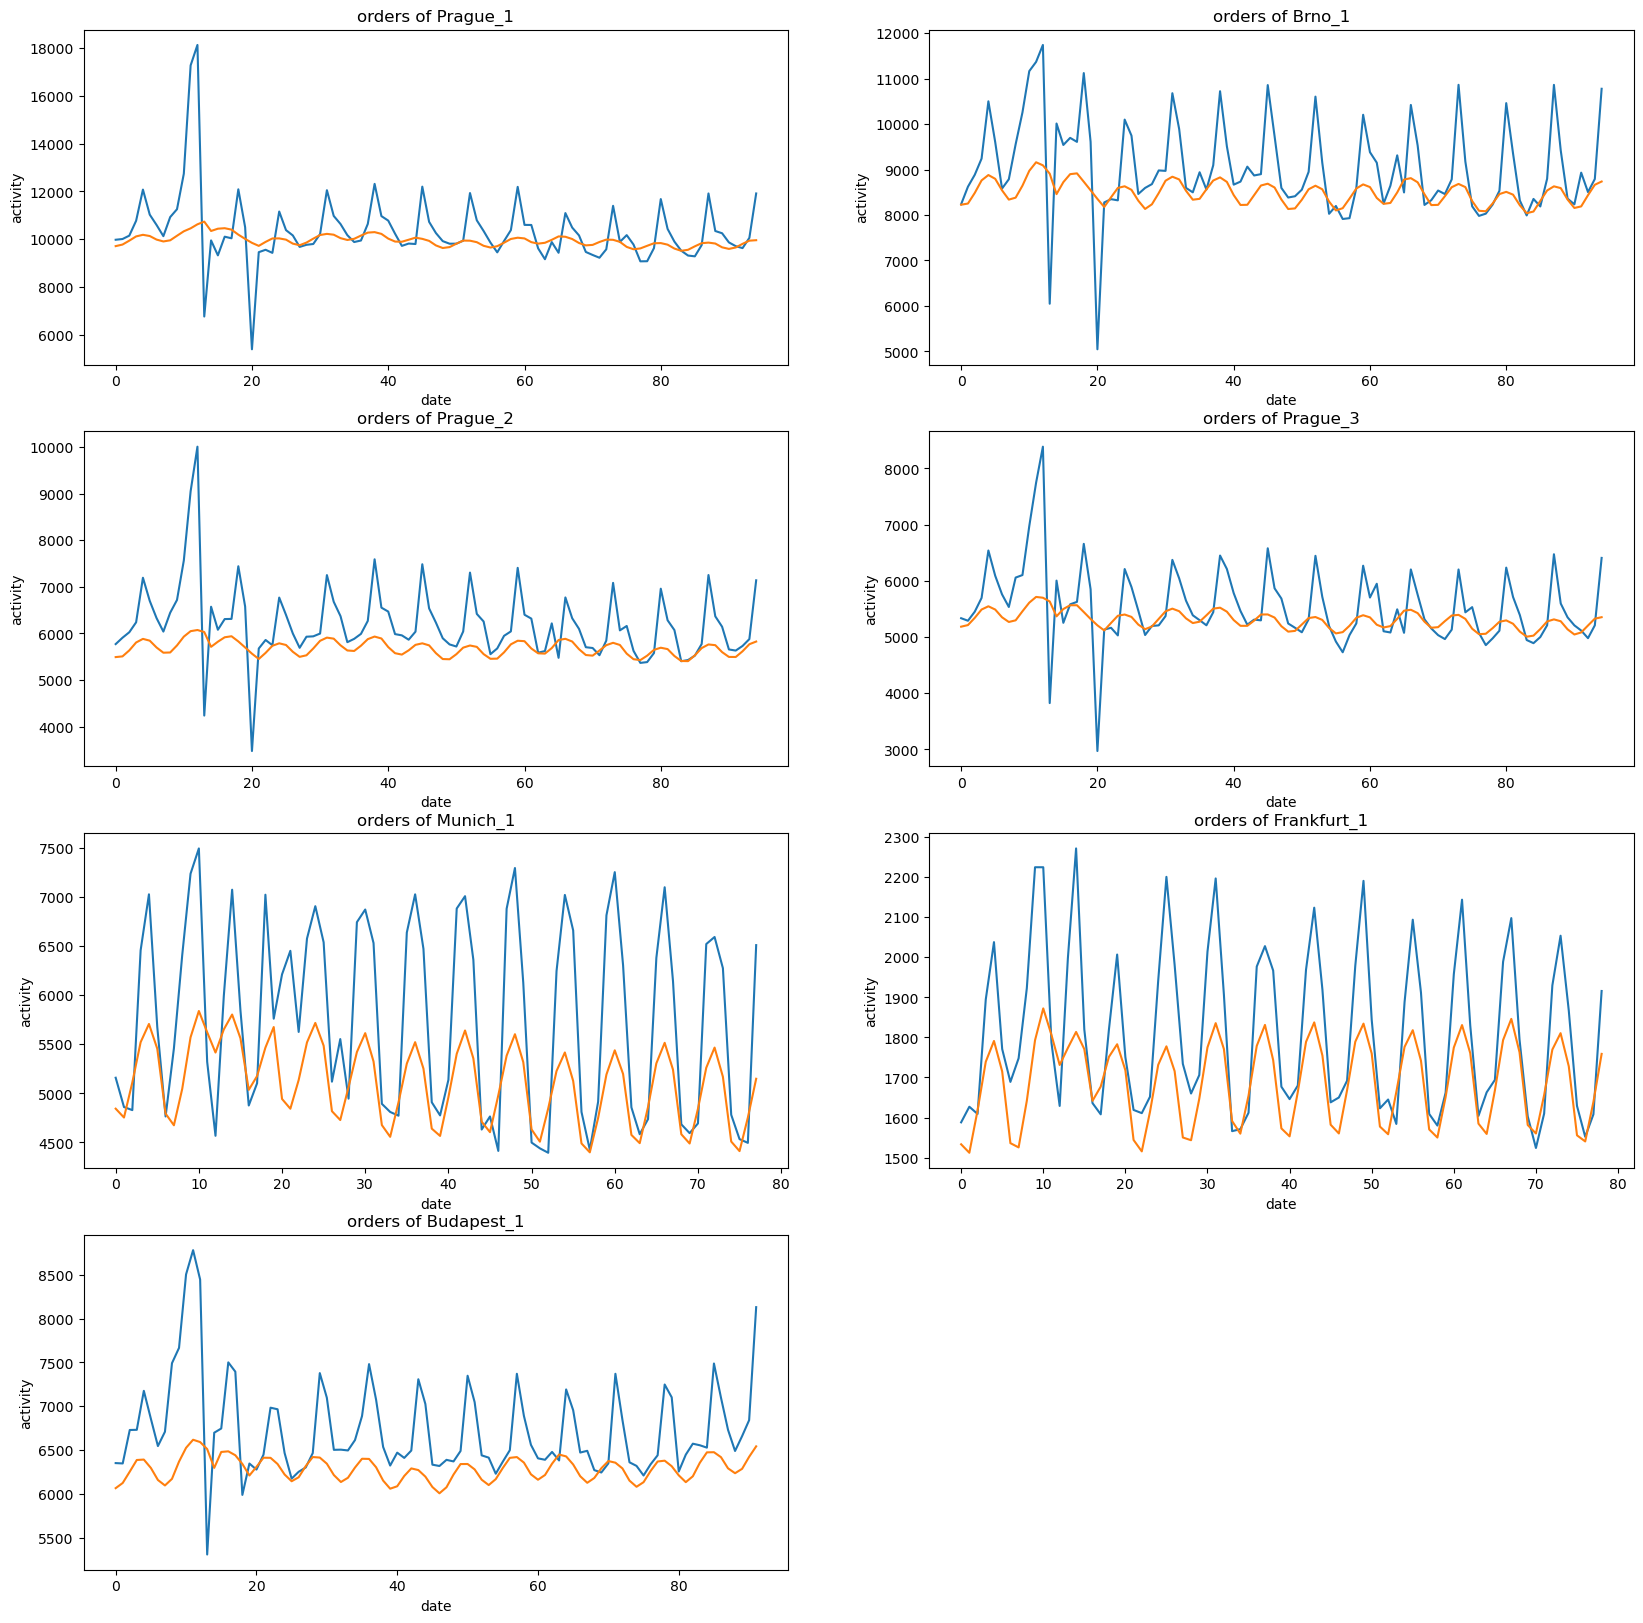

In [31]:
fig = plt.figure(figsize = (20,20))
i=1
activity='user_activity_2'
for warehouse in warehouses:
    fig.add_subplot(4,2,i)
    data=out_df[out_df['warehouse'] == warehouse]
    plt.plot(data['orders'],label='Actual active')
    plt.plot(data['orders_pred'],label='predict')
    # plt.plot(train_y,label='train')
    plt.xlabel("date")
    plt.ylabel("activity")
    plt.title(f'orders of {warehouse}')
    i+=1
plt.show()

the predict a little lower than acrual. It was a little smooth

In [47]:
#remove trend
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def remove_trend(dates, data,degree=2):
    X = np.arange(len(dates)).reshape(-1, 1)  
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, data)
    trend = model.predict(X_poly)
    detrended_data = data - trend
    return detrended_data,trend, model, poly

def add_trend(dates, detrended_data, model, poly,start=0):
    X = np.arange(len(dates)).reshape(-1, 1)
    X_poly = poly.transform(X)
    trend = model.predict(X_poly)
    return detrended_data + trend[start:]



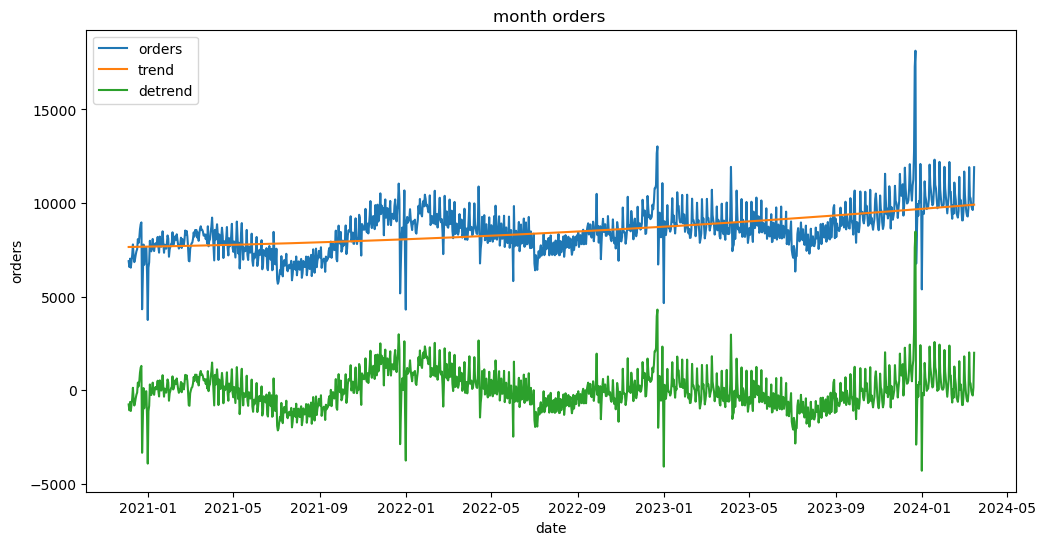

In [59]:
fig = plt.figure(figsize = (12,6))
warehouse = train_df['warehouse'].unique()[0]
warehouse_df = train_df[train_df['warehouse']==warehouse]
detrend,trend,_,_ = remove_trend(warehouse_df['date'],warehouse_df['orders'])
sns.lineplot(x="date",y="orders",data=train_df[train_df['warehouse']==warehouse],label='orders')
sns.lineplot(x='date',y=trend,data=train_df[train_df['warehouse']==warehouse],label='trend')
sns.lineplot(x='date',y=detrend,data=train_df[train_df['warehouse']==warehouse],label='detrend')
plt.xlabel("date")
plt.ylabel("orders")
plt.title(f"month orders ")
plt.legend()
plt.show()

In [60]:

def getdata1( data,n_step=14):
    data_np =data[['detrend_orders','user_activity_1','detrend_user_activity_2','month_sin','month_cos','day_of_week_sin','day_of_week_cos','day_of_year_sin','day_of_year_cos','day_sin','day_cos']].to_numpy()

    add_data =data[['holidays_id','holiday','shops_closed','combined_holidays','is_weekend']].to_numpy()
    X = []
    y = []
    for i in range(len(data_np)-n_step):
        row = np.array([r for r in data_np[i:i+n_step+1]])
        add_row = np.tile(add_data[i+n_step], (n_step+1, 1))
        row1 = np.hstack((row, add_row))
        X.append(row1)
    
    return np.array(X)

def train_predict1(train_load,val_load,test_loader,input_size,hidden_size,num_layers,output_size):
    #create model
    early_stop_callback = EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=3)
    
    # Configure Checkpoints
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min"
    )
    lstm= LSTM(input_size,hidden_size,num_layers,output_size)
    # Fit the model
    trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback])
    # trainer = L.Trainer(max_epochs=10)
    trainer.fit(model=lstm, train_dataloaders=train_load, val_dataloaders=val_loader)

    test_pred=trainer.predict(model=lstm, dataloaders = test_loader)
    test_pred=torch.cat(test_pred, dim=0)
    
    return test_pred,lstm

def reverse_predict1(scaler,pred_s,n_step,n_features,output_size):
    pred = np.zeros((pred_s.shape[0],n_step, n_features))
    pred[:, -1,:output_size] = pred_s
    pred_reshape = pred.reshape(-1, pred.shape[-1])
    pred_inverse = scaler.inverse_transform(pred_reshape)
    pred_out = pred_inverse.reshape(pred.shape)
    return pred_out[:,-1,:output_size]

def add_detrend(df,col,degree=2):
    detrend,trend,lnm,ploy = remove_trend(df['date'],df[col],degree)
    df = df.copy() 
    df.loc[:, f'detrend_{col}'] = detrend

    return df,lnm,ploy

def add_adtrend(train_df,test_df,col,lnm,ploy):
    len_train = len(train_df)
    date = np.vstack([train_df[['date']].values,test_df[['date']].values])
    test_pred = add_trend(date, test_df[f'{col}_pred_detrend'],lnm,ploy,start =len_train )
    test_df[f'{col}_pred'] = test_pred
    return test_df
    
    


In [61]:
train_df_1 = train_df_new.drop(['id','holiday_name','blackout','mov_change','frankfurt_shutdown','precipitation','snow','shutdown','mini_shutdown'],axis=1, errors='ignore')
test_df_1 =train_df_1[train_df_1['date']>'2023-12-03']
train_df_2 =train_df_1[train_df_1['date']<='2023-12-03']
train_df_1.head(3)

,warehouse,date,orders,holiday,shops_closed,user_activity_1,user_activity_2,day_of_year,is_weekend,days_since_start,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,day_sin,day_cos,holidays_id,combined_holidays
0,Prague_1,2020-12-05,6895.0,0,0,1722.0,32575.0,340,1,0,-2.449294e-16,1.0,-0.974928,-0.222521,-0.417194,0.908818,0.866025,0.500000,0,0
1,Prague_1,2020-12-06,6584.0,0,0,1688.0,32507.0,341,1,1,-2.449294e-16,1.0,-0.781831,0.623490,-0.401488,0.915864,0.951057,0.309017,0,0
2,Prague_1,2020-12-07,7030.0,0,0,1696.0,32552.0,342,0,2,-2.449294e-16,1.0,0.000000,1.000000,-0.385663,0.922640,0.994522,0.104528,0,0


In [29]:
#有历史数据训练
n_step =7
input_size = 16
hidden_size= 64
num_layers = 1
output_size=3
warehouses =train_df_1['warehouse'].unique()
out_df = pd.DataFrame()
for warehouse in warehouses:
    set_random(42)
    ware_df = train_df_1[train_df_1['warehouse']==warehouse]

    ware_df,lnm1,ploy1 = add_detrend(ware_df,'orders')
    ware_df,lnm3,ploy3 = add_detrend(ware_df,'user_activity_2')

    test_df_warehouse =ware_df[ware_df['date']>'2023-12-03']
    train_df_warehouse =ware_df[ware_df['date']<='2023-12-03']
    train_data= getdata1( train_df_warehouse,n_step=n_step)
    
    test_data= getdata1( test_df_warehouse,n_step=n_step)

    scaler  = MinMaxScaler()
    train_reshape = train_data.reshape(-1, train_data.shape[-1])
    test_reshape = test_data.reshape(-1, test_data.shape[-1])

    train_scaler_reshape = scaler.fit_transform(train_reshape)
    test_scaler_reshape = scaler.transform(test_reshape)

    train_scaler = train_scaler_reshape.reshape(train_data.shape)
    test_scaler = test_scaler_reshape.reshape(test_data.shape)
    

    train_data_X ,train_data_y= train_scaler[:,:-1,:],train_scaler[:,-1,:1]
    train_data_X =torch.tensor(train_data_X, dtype=torch.float32)
    train_data_y =torch.tensor(train_data_y, dtype=torch.float32)

    
    train_X,val_X,train_y,val_y=train_test_split(train_data_X ,train_data_y,shuffle=False,percentage=0.9)
    
    test_X ,test_y= test_scaler[:,:-1,:],test_scaler[:,-1,:1]
    test_X =torch.tensor(test_X, dtype=torch.float32)
    test_y =torch.tensor(test_y, dtype=torch.float32)
    train_dataset = MyDataset(train_X,train_y)
    val_dataset = MyDataset(val_X,val_y)
    test_dataset = MyDataset(test_X,test_y)
    
    train_loader=DataLoader(train_dataset, batch_size=16,  shuffle=True,num_workers=0)
    val_loader=DataLoader(val_dataset, batch_size=16,  shuffle=False,num_workers=0)
    test_loader=DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=0)

    # 反归一化
    test_pred_scaler,model=train_predict1(train_loader,val_loader,test_loader,input_size,hidden_size,num_layers,output_size)
    pred_detrend=reverse_predict1(scaler,test_pred_scaler,n_step+1,train_data.shape[2],output_size)


    #删除test中前n——step行
    test_df_warehouse_new =test_df_warehouse.drop(test_df_warehouse.index[:n_step]).reset_index(drop=False)


    test_pred_df = pd.DataFrame(pred_detrend, columns=['orders_pred_detrend','user_activity_1_pred','user_activity_2_pred_detrend'])
    test_pred_df.index=test_df_warehouse_new.index
    result = pd.concat([test_df_warehouse_new, test_pred_df], axis=1)

    #add trend
    result = add_adtrend(train_df_warehouse,result,'orders',lnm1,ploy1)
    # result = add_adtrend(result,'user_activity_1',lnm2,ploy2)
    result = add_adtrend(train_df_warehouse,result,'user_activity_2',lnm3,ploy3)
    
    out_df = pd.concat([out_df, result], axis=0)
    # draw_train_plot(warehouse,result,test_pred)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 21.0 K | train
1 | fc        | Sequential | 195    | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

Training: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 21.0 K | train
1 | fc        | Sequential | 195    | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

Training: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 21.0 K | train
1 | fc        | Sequential | 195    | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

Training: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 21.0 K | train
1 | fc        | Sequential | 195    | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

Training: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 21.0 K | train
1 | fc        | Sequential | 195    | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

Training: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 21.0 K | train
1 | fc        | Sequential | 195    | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

Training: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 21.0 K | train
1 | fc        | Sequential | 195    | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

Training: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

D:\Software\anaconda\envs\Pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [30]:
from sklearn.metrics import mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

0.009315595300522141 6.851937606539499


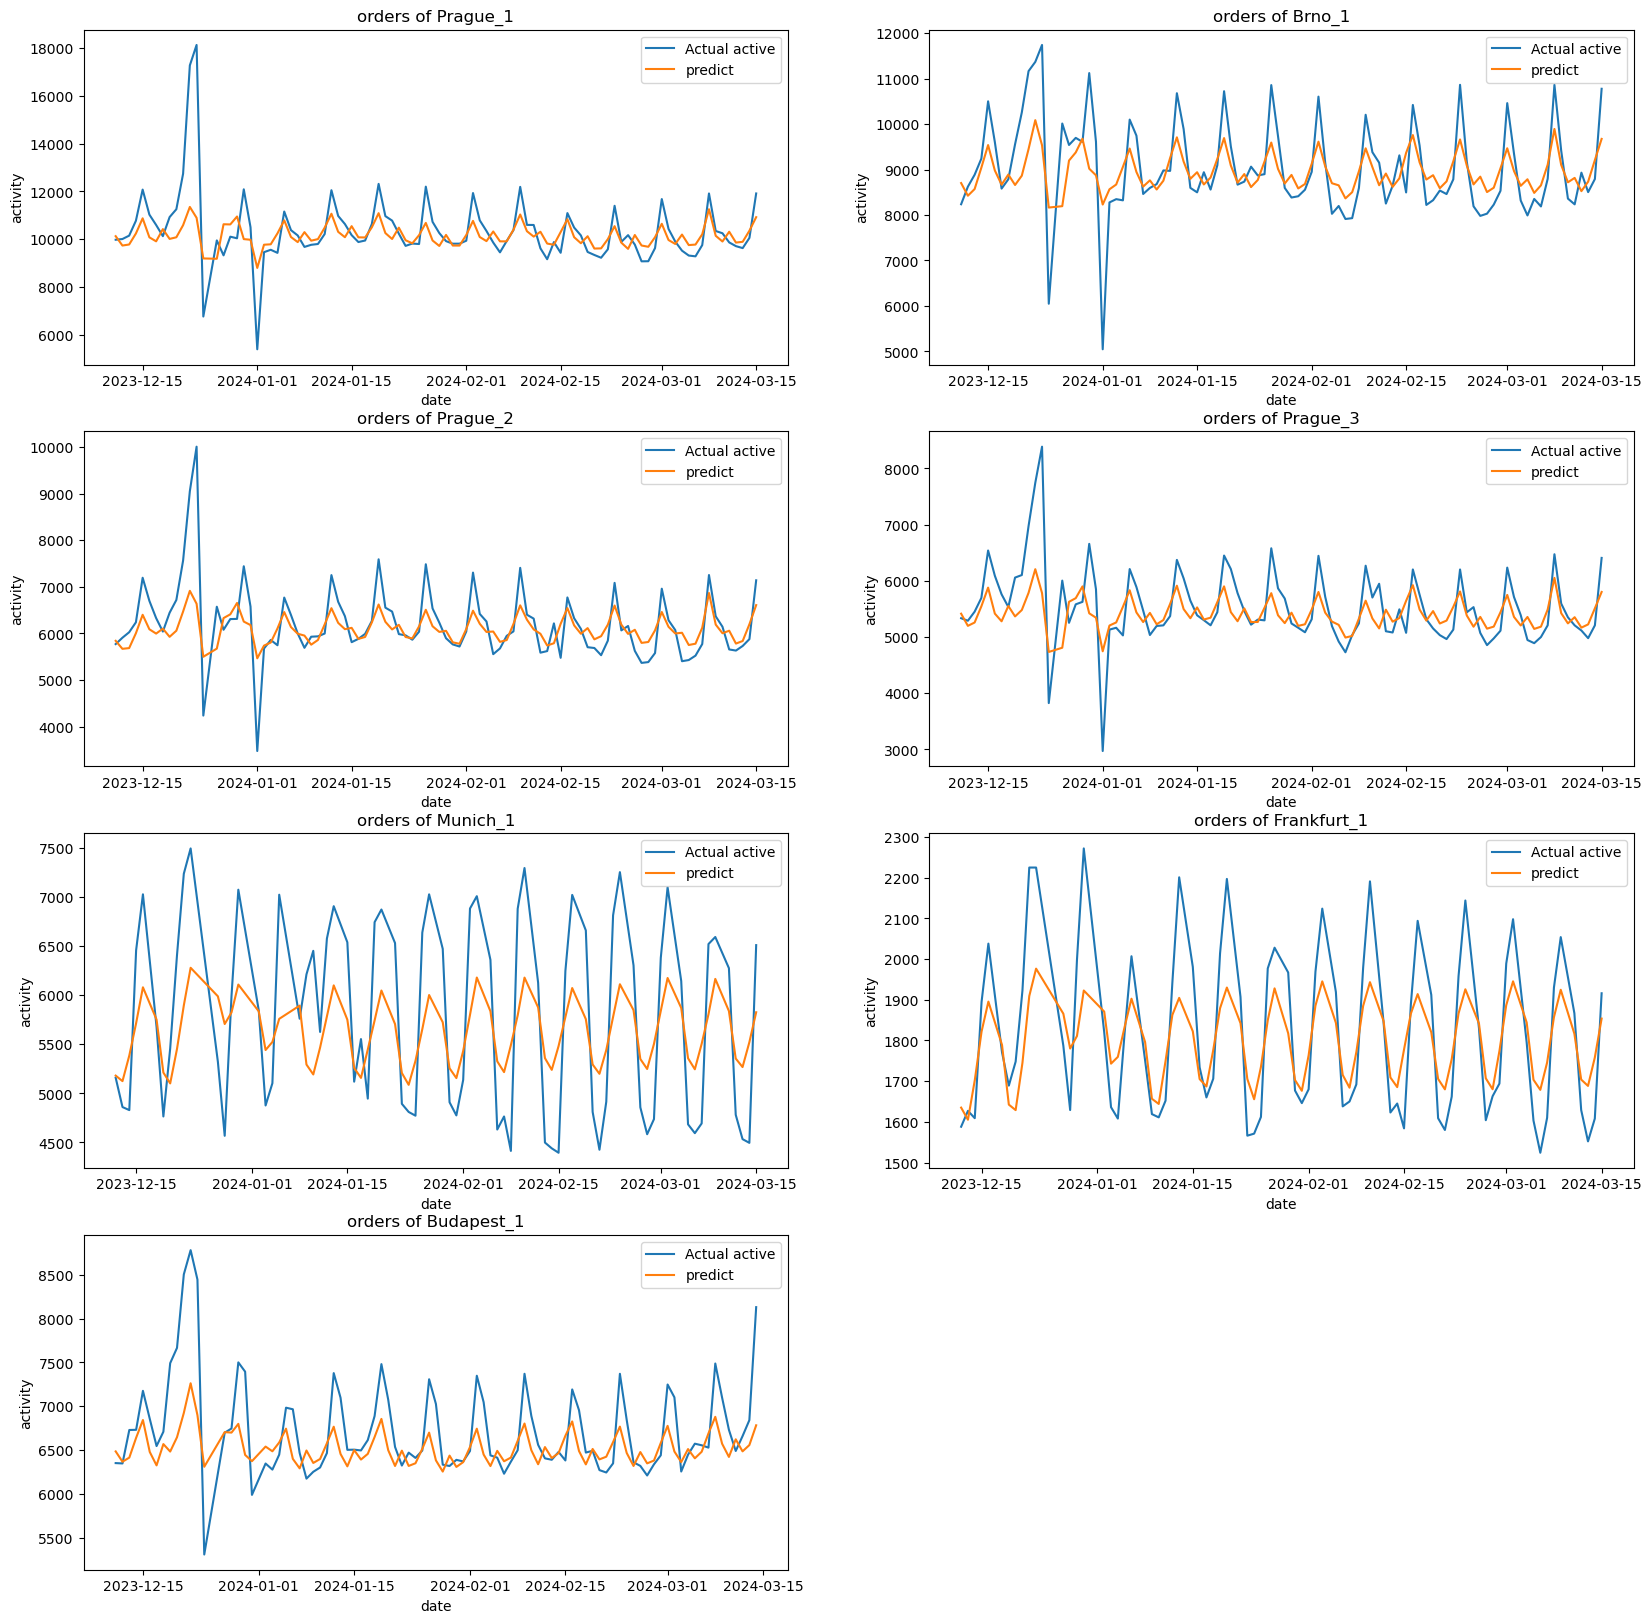

In [31]:
loss =mean_squared_log_error(out_df['orders'],out_df['orders_pred'])
loss1 =mean_absolute_percentage_error(out_df['orders'],out_df['orders_pred'])
print(loss,loss1)
fig = plt.figure(figsize = (20,20))
i=1
activity='user_activity_2'
for warehouse in warehouses:
    fig.add_subplot(4,2,i)
    data=out_df[out_df['warehouse'] == warehouse]
    plt.plot(data['date'],data['orders'],label='Actual active')
    plt.plot(data['date'],data['orders_pred'],label='predict')
    # plt.plot(train_y,label='train')
    plt.xlabel("date")
    plt.ylabel("activity")
    plt.title(f'orders of {warehouse}')
    i+=1
    plt.legend()
plt.show()

In [32]:

def train_loop(train_load,val_load):
    #create model
    early_stop_callback = EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=3)
    
    # Configure Checkpoints
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min"
    )
    lstm= LSTM(input_size,hidden_size,num_layers,output_size)
    # Fit the model
    trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback])
    # trainer = L.Trainer(max_epochs=10)
    trainer.fit(model=lstm, train_dataloaders=train_load, val_dataloaders=val_loader)

    
    return lstm 

def getdata2( data,n_step=14):
    data_np =data[['detrend_orders','month_sin','month_cos','day_of_week_sin','day_of_week_cos','day_of_year_sin','day_of_year_cos','day_sin','day_cos']].to_numpy()

    add_data =data[['holidays_id','holiday','shops_closed','combined_holidays','is_weekend']].to_numpy()
    X = []
    y = []
    for i in range(len(data_np)-n_step):
        row = np.array([r for r in data_np[i:i+n_step+1]])
        add_row = np.tile(add_data[i+n_step], (n_step+1, 1))
        row1 = np.hstack((row, add_row))
        X.append(row1)
    
    return np.array(X)

def predict_loop(model,test_df_sc,init_data,n_step):
    predictions = []
    current_input =init_data[:,:9]
    months = torch.tensor(test_df_sc[['month_sin','month_cos','day_of_week_sin','day_of_week_cos','day_of_year_sin','day_of_year_cos','day_sin','day_cos']].to_numpy(),dtype=torch.float32)
    adds = torch.tensor(test_df_sc[['holidays_id','holiday','shops_closed','combined_holidays','is_weekend']].to_numpy(),dtype=torch.float32)
    model.eval()
    current_input =torch.tensor(current_input, dtype=torch.float32)

    for i in range(len(test_df_sc)):
        add_row =  adds[i].expand(current_input.size(0), -1)
        row = torch.cat((current_input, add_row), dim=1)
        row = torch.tensor(row, dtype=torch.float32)
        y_pred=model(row.unsqueeze(0))
        predictions.append(y_pred.detach().numpy().flatten())
        new_row = torch.cat((y_pred,months[i].unsqueeze(0)),dim=1)
        current_input = torch.cat((current_input[1:], new_row.squeeze(-1)), dim=0)
    predictions = np.array(predictions)

    return predictions

class MinMax3D:
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range
        self.min_ = None
        self.scale_ = None

    def fit(self, X):
        self.min_ = np.min(X, axis=(0,1))
        self.max_ = np.max(X, axis=(0,1))
        self.scale_ = self.max_ - self.min_

        # avoiding division by zero
        self.scale_[self.scale_ == 0] = 1

    def fit_traninsform(self,X):
        self.min_ = np.min(X, axis=(0,1))
        self.max_ = np.max(X, axis=(0,1))
        self.scale_ = self.max_ - self.min_

        # avoiding division by zero
        self.scale_[self.scale_ == 0] = 1
        range_min, range_max = self.feature_range   

        # for i in range(X.shape[0]):
        #     for j in range(X.shape[1]):
        #         X[i,j] =(train_data[i,j] - min) / (max-min)
        X = (X - self.min_) / self.scale_
        X = X * (range_max - range_min) + range_min
        return X

    def inverse_transform(self,X,output_size):
        range_min, range_max = self.feature_range   
        X = (X - range_min) / (range_max - range_min)
        X = X * self.scale_[:output_size] + self.min_[:output_size]
        return X

    def traninsform_test(self,X):
        range_min, range_max = self.feature_range   
        X = (X - self.min_[output_size:]) / self.scale_[output_size:]
        X = X * (range_max - range_min) + range_min
        return X

In [33]:
test_df = pd.read_csv("data/test.csv")
test_df,bin_features =process_date(test_df)
test_df,holidays=prepare_holidays(test_df)


# train test without actural orders

In [34]:

n_step =7
input_size = 14
hidden_size= 64
num_layers = 1
output_size=1
batch_size = 16
warehouses =train_df_1['warehouse'].unique()
out_df4 = pd.DataFrame()
for warehouse in warehouses:
    set_random(42)
    ware_df = train_df_1[train_df_1['warehouse']==warehouse]

    ware_df,lnm1,ploy1 = add_detrend(ware_df,'orders')

    train_df_warehouse =ware_df[ware_df['date']<='2023-12-03']
    train_data= getdata2( train_df_warehouse,n_step=n_step)
    

    min_max_scaler=MinMax3D()
    train_scaler = min_max_scaler.fit_traninsform(train_data)
    # print(train_scaler.shape)

    train_data_X ,train_data_y= train_scaler[:,:-1,:],train_scaler[:,-1,:1]
    train_data_X =torch.tensor(train_data_X, dtype=torch.float32)
    train_data_y =torch.tensor(train_data_y, dtype=torch.float32)
    
    train_X,val_X,train_y,val_y=train_test_split(train_data_X ,train_data_y,shuffle=False,percentage=0.9)
    train_dataset = MyDataset(train_X,train_y)
    val_dataset = MyDataset(val_X,val_y)

    train_loader=DataLoader(train_dataset, batch_size=batch_size,  shuffle=True,num_workers=0)
    val_loader=DataLoader(val_dataset, batch_size=batch_size,  shuffle=False,num_workers=0)

    #Preprocessing test data
    test_df_warehouse =ware_df[ware_df['date']>'2023-12-03']

    test_warehouse_1 = test_df_warehouse[['holidays_id','holiday','shops_closed','combined_holidays','is_weekend','month_sin',
                    'month_cos','day_of_week_sin','day_of_week_cos','day_of_year_sin','day_of_year_cos','day_sin','day_cos']]
    
    test_scaler = min_max_scaler.traninsform_test(test_warehouse_1)
    init_data =train_scaler[-1,1:,:]
    


    #train and predict 
    model=train_loop(train_loader,val_loader)

    test_pred_scaler = predict_loop(model,test_scaler,init_data,n_step)
    test_pred = min_max_scaler.inverse_transform(test_pred_scaler,output_size)
    test_pred_df = pd.DataFrame(test_pred,index =test_df_warehouse.index, columns=['orders_pred_detrend'])
    result = pd.concat([test_df_warehouse,test_pred_df], axis=1)
    #增加trend
    result = add_adtrend(train_df_warehouse,result,'orders',lnm1,ploy1)

    # loss = 
    out_df4 = pd.concat([out_df4,result], axis=0)

loss = mean_squared_log_error(out_df4['orders'],out_df4['orders_pred']  )

loss
    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 20.5 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 20.5 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 20.5 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 20.5 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 20.5 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 20.5 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 20.5 K | train
1 | fc        | Sequential | 65     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)


0.028474109933130216

0.028474109933130216 6.851937606539499


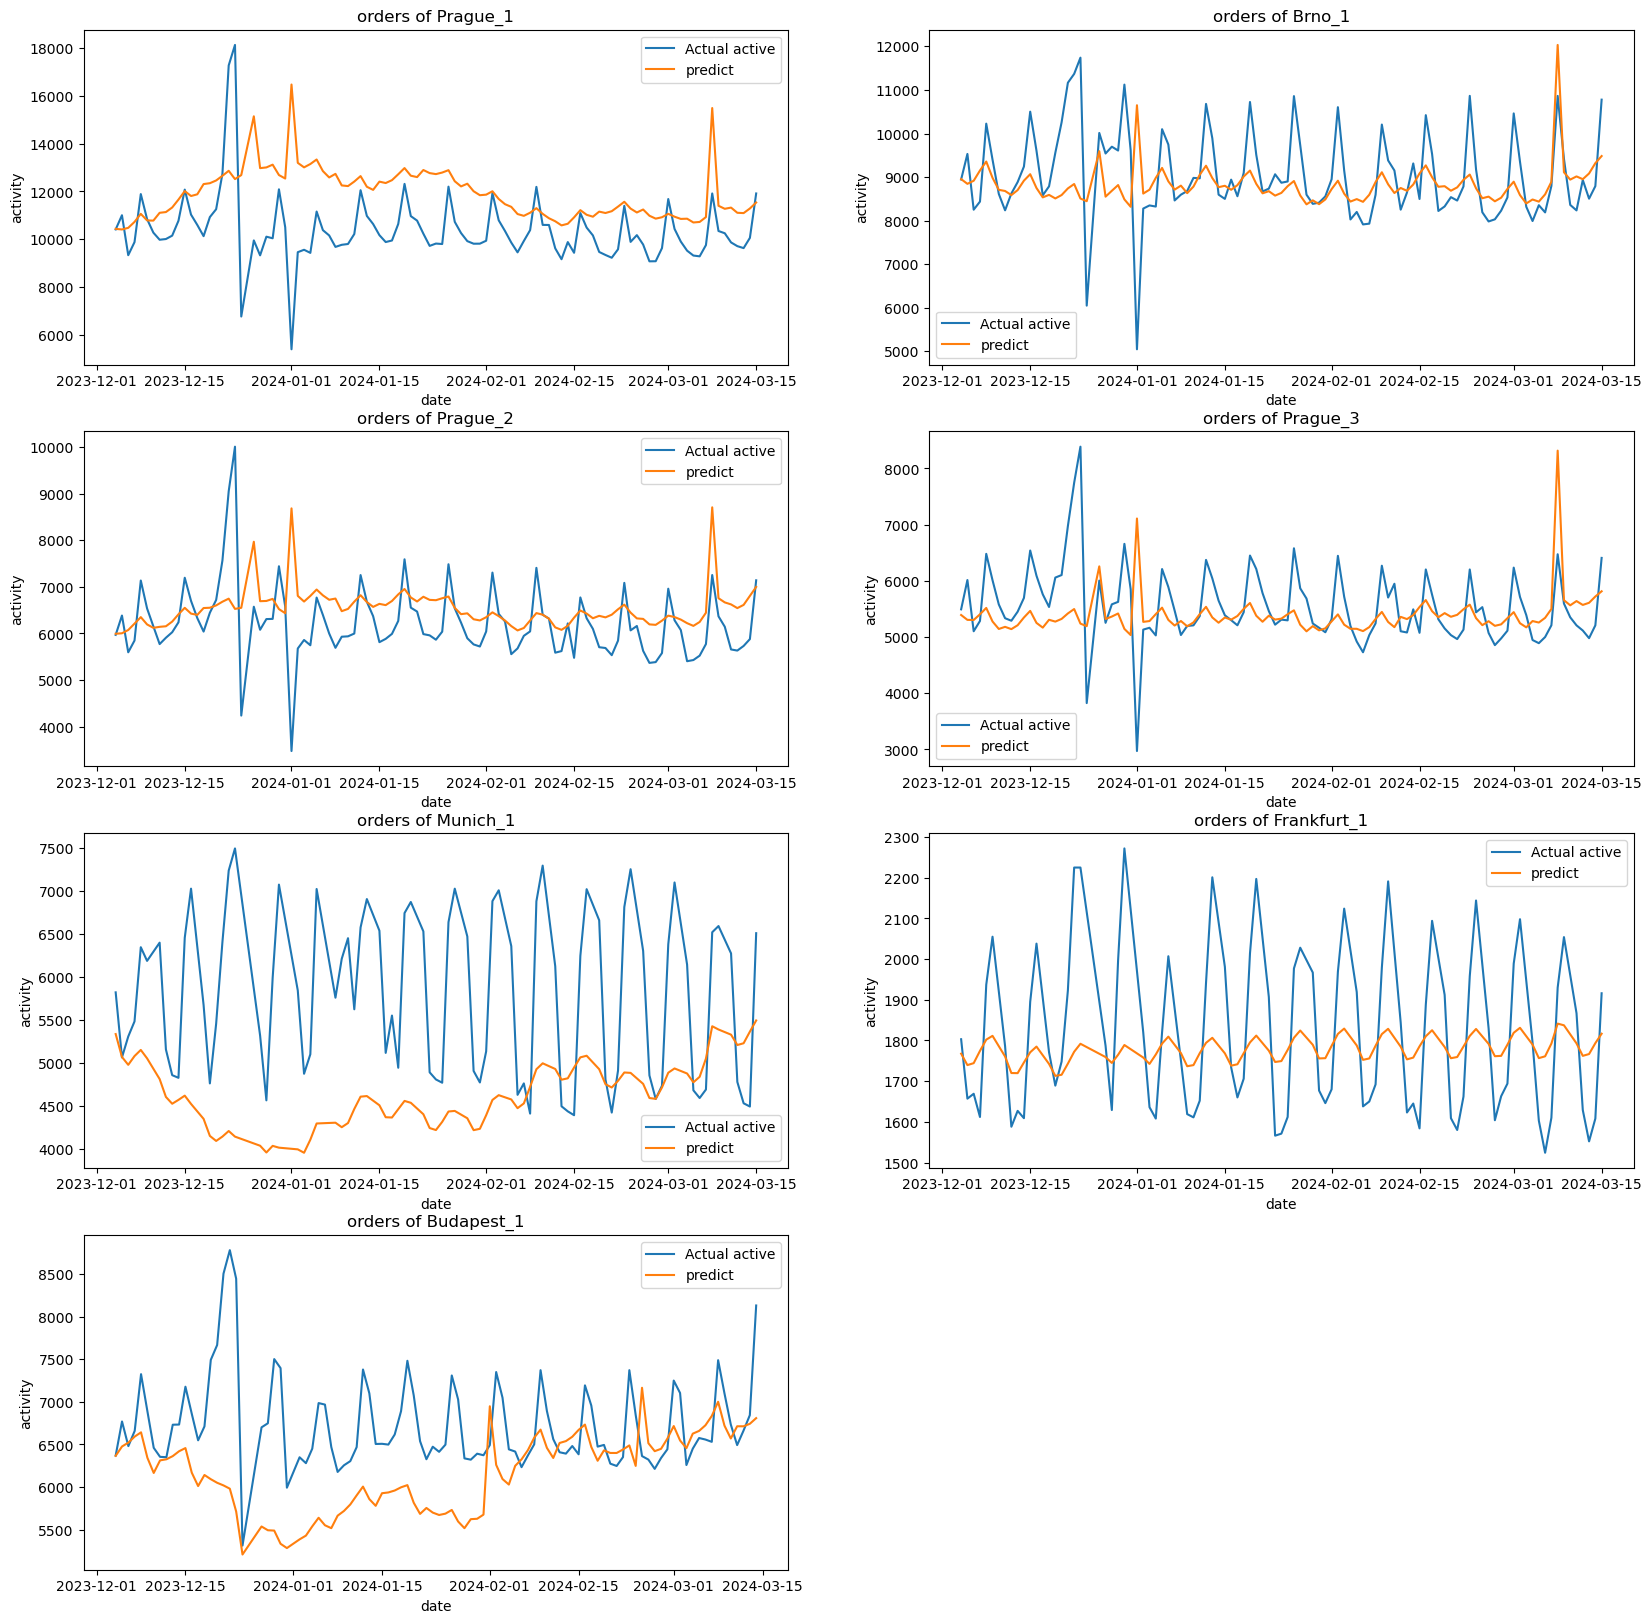

In [35]:


loss =mean_squared_log_error(out_df4['orders'],out_df4['orders_pred'])
loss1 =mean_absolute_percentage_error(out_df['orders'],out_df['orders_pred'])
print(loss,loss1)
fig = plt.figure(figsize = (20,20))
i=1
activity='user_activity_2'
for warehouse in warehouses:
    fig.add_subplot(4,2,i)
    data=out_df4[out_df4['warehouse'] == warehouse]
    plt.plot(data['date'],data['orders'],label='Actual active')
    plt.plot(data['date'],data['orders_pred'],label='predict')
    # plt.plot(train_y,label='train')
    plt.xlabel("date")
    plt.ylabel("activity")
    plt.title(f'orders of {warehouse}')
    i+=1
    plt.legend()
plt.show()

#### we get MSLE: 0.028474109933130216 and MAPE:6.851937606539499

### train and predict test for test set

In [36]:
n_step =7
input_size = 14
hidden_size= 32
num_layers = 1
output_size=1
warehouses =train_df_1['warehouse'].unique()
out_df2 = pd.DataFrame()
batch_size=32
for warehouse in warehouses:
    set_random(42)
    train_df_warehouse = train_df_1[train_df_1['warehouse']==warehouse]

    train_df_warehouse,lnm1,ploy1 = add_detrend(train_df_warehouse,'orders')
    train_data= getdata2( train_df_warehouse,n_step=n_step)
    

    min_max_scaler=MinMax3D()
    train_scaler = min_max_scaler.fit_traninsform(train_data)

    train_data_X ,train_data_y= train_scaler[:,:-1,:],train_scaler[:,-1,:1]
    train_data_X =torch.tensor(train_data_X, dtype=torch.float32)
    train_data_y =torch.tensor(train_data_y, dtype=torch.float32)
    
    train_X,val_X,train_y,val_y=train_test_split(train_data_X ,train_data_y,shuffle=False,percentage=0.9)
    train_dataset = MyDataset(train_X,train_y)
    val_dataset = MyDataset(val_X,val_y)

    train_loader=DataLoader(train_dataset, batch_size=batch_size,  shuffle=True,num_workers=0)
    val_loader=DataLoader(val_dataset, batch_size=batch_size,  shuffle=False,num_workers=0)

    #Preprocessing test data
    test_df_warehouse = test_df[test_df['warehouse']==warehouse]


    test_warehouse_1 = test_df_warehouse[['holidays_id','holiday','shops_closed','combined_holidays','is_weekend','month_sin',
                    'month_cos','day_of_week_sin','day_of_week_cos','day_of_year_sin','day_of_year_cos','day_sin','day_cos']]

    test_scaler = min_max_scaler.traninsform_test(test_warehouse_1)
    init_data =train_scaler[-1,1:]
    

    #train and predict 
    model=train_loop(train_loader,val_loader)

    test_pred_scaler = predict_loop(model,test_scaler,init_data,n_step)
    test_pred = min_max_scaler.inverse_transform(test_pred_scaler,output_size)

    test_pred_df = pd.DataFrame(test_pred,index =test_df_warehouse.index, columns=['orders_pred_detrend'])
    result = pd.concat([test_df_warehouse,test_pred_df], axis=1)
    #增加trend
    result = add_adtrend(train_df_warehouse,result,'orders',lnm1,ploy1)

    # loss = 
    out_df2 = pd.concat([out_df2,result], axis=0)


    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 6.1 K  | train
1 | fc        | Sequential | 33     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 6.1 K  | train
1 | fc        | Sequential | 33     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 6.1 K  | train
1 | fc        | Sequential | 33     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 6.1 K  | train
1 | fc        | Sequential | 33     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 6.1 K  | train
1 | fc        | Sequential | 33     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 6.1 K  | train
1 | fc        | Sequential | 33     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 6.1 K  | train
1 | fc        | Sequential | 33     | train
2 | criterion | MSELoss    | 0      | train
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\JAMES\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\JAMES\AppData\Local\Temp\ipykernel_1144\3604704897.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)


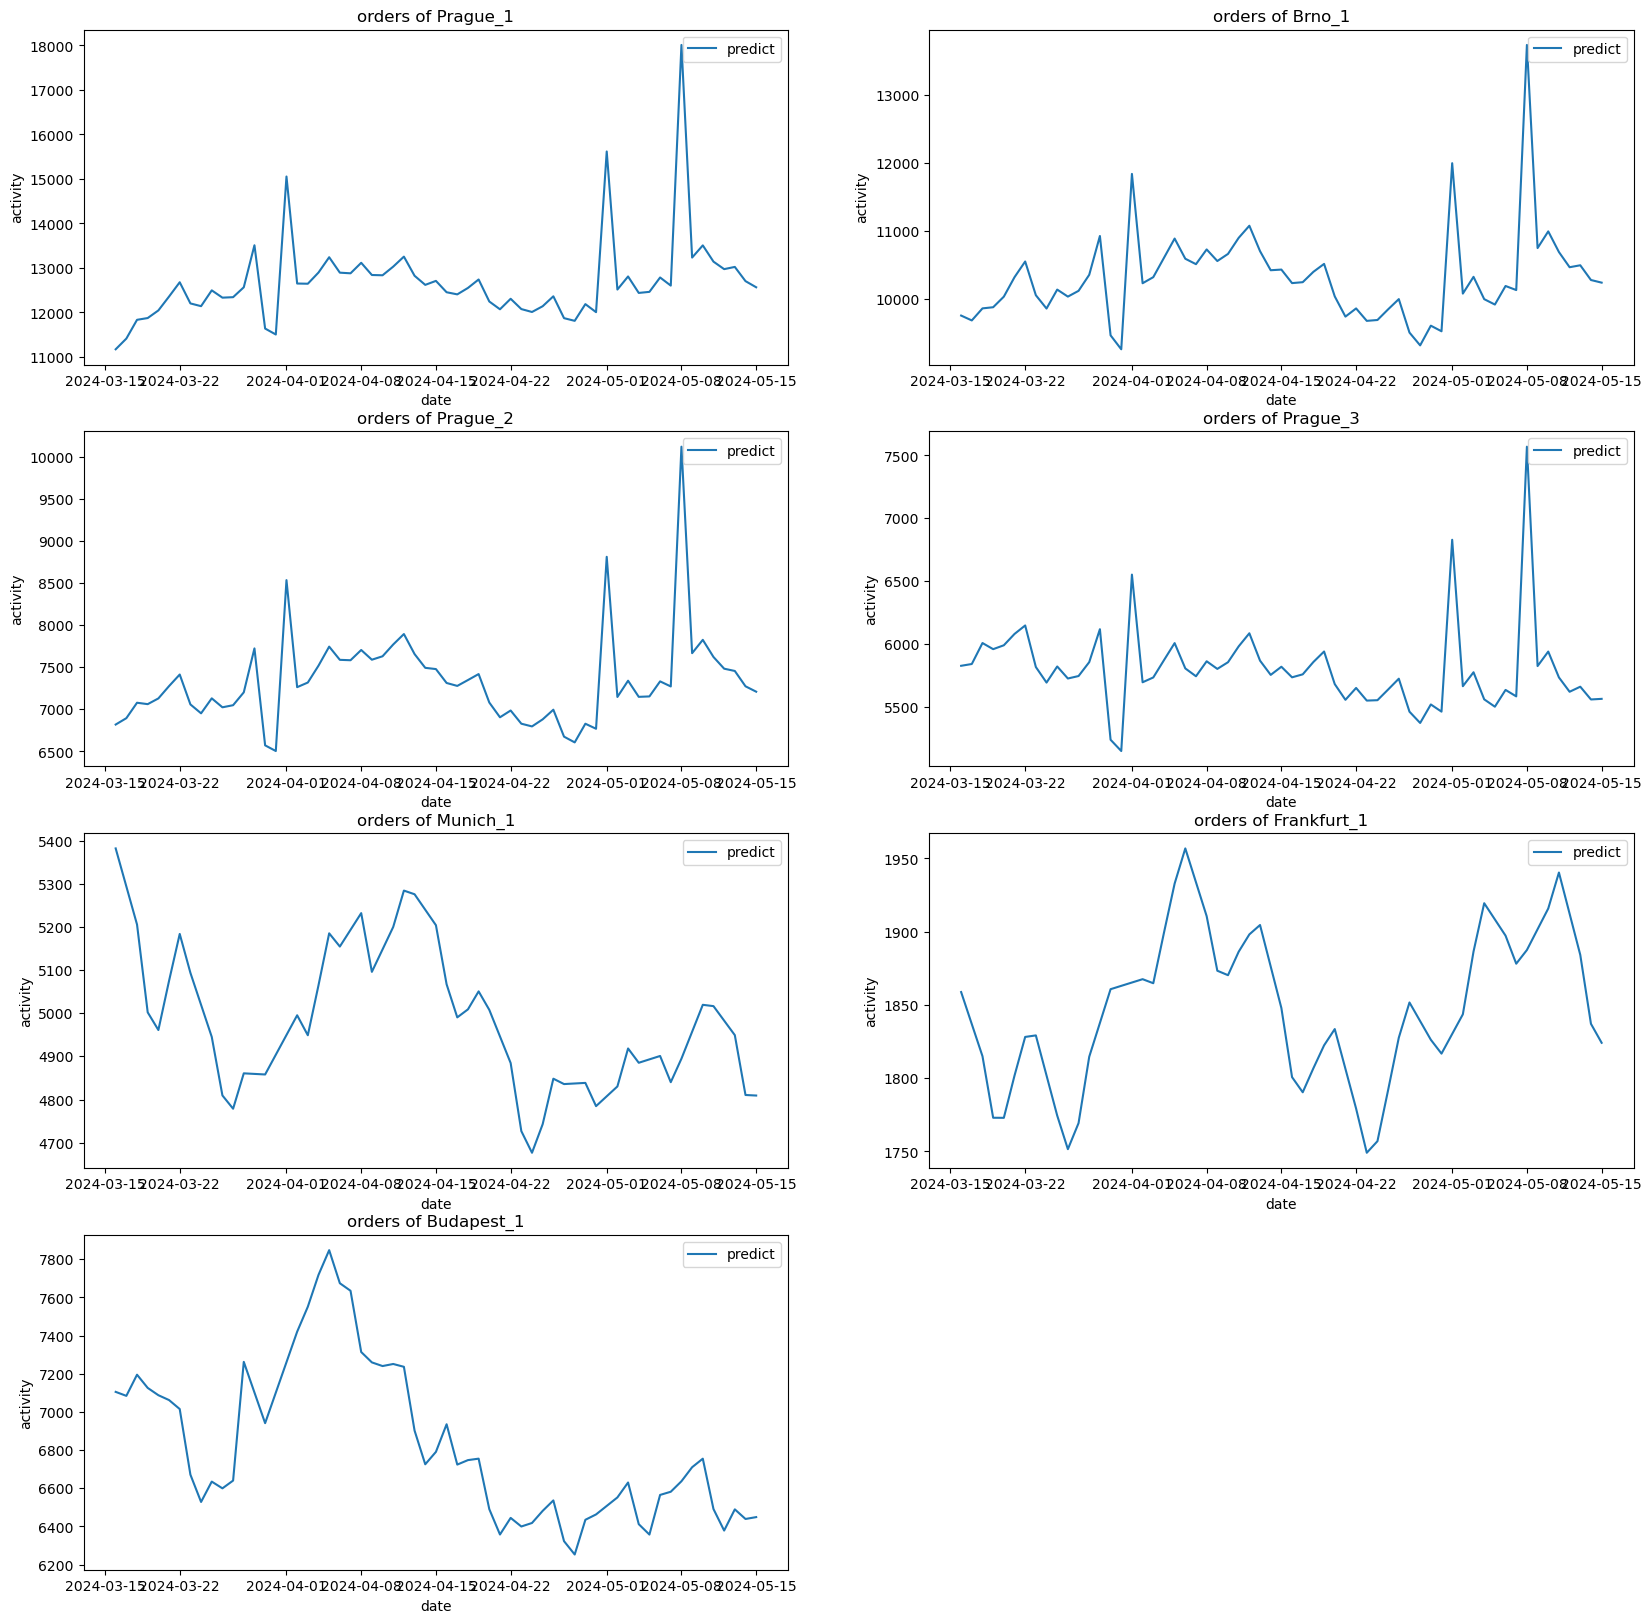

In [37]:
fig = plt.figure(figsize = (20,20))
i=1
activity='user_activity_2'
for warehouse in warehouses:
    fig.add_subplot(4,2,i)
    data=out_df2[out_df2['warehouse'] == warehouse]
    # plt.plot(data['orders'],label='Actual active')
    plt.plot(data['date'],data['orders_pred'],label='predict')
    # plt.plot(train_y,label='train')
    plt.xlabel("date")
    plt.ylabel("activity")
    plt.title(f'orders of {warehouse}')
    i+=1
    plt.legend()
plt.show()

In [40]:
out_df3 = out_df2[['id','orders_pred']]
out_df3.to_csv('output3.csv', index=False)